## Sentiment Analysis for Mental Health


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Install library
!pip install simpletransformers

In [6]:

!pip install wordcloud
!pip install torch



In [7]:
# Import library
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from wordcloud import WordCloud
import re
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
string.punctuation
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from simpletransformers.classification import ClassificationModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Extraction

In [8]:
# Import and display dataset
df = pd.read_csv("/content/drive/MyDrive/mini project/mbti_1.csv")
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [9]:
# Check total rows and columns in dataset
df.shape

(8675, 2)

In [10]:
# Describe pattern from dataset
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'It has been too long since I have been on per...
freq,1832,1


In [11]:
most_frequent_type = df['type'].value_counts().idxmax()
most_frequent_count = df['type'].value_counts().max()

print(f"The most frequent MBTI type is '{most_frequent_type}' with {most_frequent_count} occurrences.")


The most frequent MBTI type is 'INFP' with 1832 occurrences.


In [12]:
# Check data types from each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [13]:
# Check missing values
df.isnull().sum()

,0
type,0
posts,0


In [14]:
# Show data that have missing values
df.loc[df.isnull().any(axis=1)]

,type,posts


In [15]:
# Fill misisng values
df.fillna('unknown', inplace=True)
df.isnull().sum()

,0
type,0
posts,0


### Text Pre-processing

In [16]:
#selection data
text = df[['posts']]
text.head()

,posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,'I'm finding the lack of me in these posts ver...
2,'Good one _____ https://www.youtube.com/wat...
3,"'Dear INTP, I enjoyed our conversation the o..."
4,'You're fired.|||That's another silly misconce...


In [17]:
# Function to remove links
def remove_links(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

df['posts'] = df['posts'].apply(remove_links)

df.head()


,type,posts
0,INFJ,' and intj moments sportscenter not top ten...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,"'Good one _____ course, to which I say I k..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [18]:
# List of MBTI types (lowercase to match all cases)
mbti_types = ['intj', 'intp', 'entj', 'entp',
              'infj', 'infp', 'enfj', 'enfp',
              'istj', 'istp', 'estj', 'estp',
              'isfj', 'isfp', 'esfj', 'esfp']

# Function to remove MBTI type names
def remove_mbti_types(text):
    pattern = r'\b(?:' + '|'.join(mbti_types) + r')\b'
    return re.sub(pattern, '', text, flags=re.IGNORECASE)

# Apply function to the posts column
df['posts'] = df['posts'].apply(remove_mbti_types)

df.head()


,type,posts
0,INFJ,' and moments sportscenter not top ten pla...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,"'Good one _____ course, to which I say I k..."
3,INTJ,"'Dear , I enjoyed our conversation the other..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [19]:
# Function to remove punctuation
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

df['posts'] = df['posts'].apply(remove_punctuation)

df.head()

,type,posts
0,INFJ,and moments sportscenter not top ten play...
1,ENTP,Im finding the lack of me in these posts very ...
2,INTP,Good one course to which I say I know tha...
3,INTJ,Dear I enjoyed our conversation the other d...
4,ENTJ,Youre firedThats another silly misconception T...


In [20]:
#setting lower case
df['posts'] = df['posts'].str.lower()
df.head()

,type,posts
0,INFJ,and moments sportscenter not top ten play...
1,ENTP,im finding the lack of me in these posts very ...
2,INTP,good one course to which i say i know tha...
3,INTJ,dear i enjoyed our conversation the other d...
4,ENTJ,youre firedthats another silly misconception t...


In [21]:
# Function to tokenize text
def tokenization(text):
    tokens = re.split(r'\W+', text)  # Corrected '\W+' to properly split on non-word characters
    return tokens

# Applying tokenization
df['posts_tokenized'] = df['posts'].apply(tokenization)

df.head()

,type,posts,posts_tokenized
0,INFJ,and moments sportscenter not top ten play...,"[, and, moments, sportscenter, not, top, ten, ..."
1,ENTP,im finding the lack of me in these posts very ...,"[im, finding, the, lack, of, me, in, these, po..."
2,INTP,good one course to which i say i know tha...,"[good, one, course, to, which, i, say, i, know..."
3,INTJ,dear i enjoyed our conversation the other d...,"[dear, i, enjoyed, our, conversation, the, oth..."
4,ENTJ,youre firedthats another silly misconception t...,"[youre, firedthats, another, silly, misconcept..."


In [22]:
# Initialize Porter Stemmer
porter_stemmer = PorterStemmer()

# Function to apply stemming
def stemming(text):
    return [porter_stemmer.stem(word) for word in text]

# Apply stemming to the tokenized column
df['posts_stemmed'] = df['posts_tokenized'].apply(stemming)

df.head()


,type,posts,posts_tokenized,posts_stemmed
0,INFJ,and moments sportscenter not top ten play...,"[, and, moments, sportscenter, not, top, ten, ...","[, and, moment, sportscent, not, top, ten, pla..."
1,ENTP,im finding the lack of me in these posts very ...,"[im, finding, the, lack, of, me, in, these, po...","[im, find, the, lack, of, me, in, these, post,..."
2,INTP,good one course to which i say i know tha...,"[good, one, course, to, which, i, say, i, know...","[good, one, cours, to, which, i, say, i, know,..."
3,INTJ,dear i enjoyed our conversation the other d...,"[dear, i, enjoyed, our, conversation, the, oth...","[dear, i, enjoy, our, convers, the, other, day..."
4,ENTJ,youre firedthats another silly misconception t...,"[youre, firedthats, another, silly, misconcept...","[your, firedthat, anoth, silli, misconcept, th..."


In [23]:
#defining the object for lemmatizing
lemmatizer = WordNetLemmatizer()

#defining a function for lemmatizing
def lemmatize_words(text):
    lemma_text = [lemmatizer.lemmatize(word) for word in text]
    return lemma_text

#applying the function
df['posts_lemmatized'] = df['posts_stemmed'].apply(lambda text: lemmatize_words(text))
df.head()

,type,posts,posts_tokenized,posts_stemmed,posts_lemmatized
0,INFJ,and moments sportscenter not top ten play...,"[, and, moments, sportscenter, not, top, ten, ...","[, and, moment, sportscent, not, top, ten, pla...","[, and, moment, sportscent, not, top, ten, pla..."
1,ENTP,im finding the lack of me in these posts very ...,"[im, finding, the, lack, of, me, in, these, po...","[im, find, the, lack, of, me, in, these, post,...","[im, find, the, lack, of, me, in, these, post,..."
2,INTP,good one course to which i say i know tha...,"[good, one, course, to, which, i, say, i, know...","[good, one, cours, to, which, i, say, i, know,...","[good, one, cours, to, which, i, say, i, know,..."
3,INTJ,dear i enjoyed our conversation the other d...,"[dear, i, enjoyed, our, conversation, the, oth...","[dear, i, enjoy, our, convers, the, other, day...","[dear, i, enjoy, our, convers, the, other, day..."
4,ENTJ,youre firedthats another silly misconception t...,"[youre, firedthats, another, silly, misconcept...","[your, firedthat, anoth, silli, misconcept, th...","[your, firedthat, anoth, silli, misconcept, th..."


### Exploratory Data Analysis (EDA)

In [24]:
#selection data
df_new = df[['posts']]
df_new.head()

,posts
0,and moments sportscenter not top ten play...
1,im finding the lack of me in these posts very ...
2,good one course to which i say i know tha...
3,dear i enjoyed our conversation the other d...
4,youre firedthats another silly misconception t...


In [25]:
mbti_to_big5 = {
    "INTJ":  [0.8, 0.8, 0.2, 0.3, 0.7],
    "INTP":  [0.9, 0.4, 0.3, 0.4, 0.6],
    "ENTJ":  [0.8, 0.9, 0.8, 0.4, 0.5],
    "ENTP":  [0.9, 0.4, 0.9, 0.5, 0.6],
    "INFJ":  [0.7, 0.7, 0.3, 0.9, 0.8],
    "INFP":  [0.8, 0.5, 0.4, 0.9, 0.9],
    "ENFJ":  [0.8, 0.7, 0.9, 0.9, 0.7],
    "ENFP":  [0.9, 0.3, 0.9, 0.8, 0.8],
    "ISTJ":  [0.3, 0.9, 0.2, 0.4, 0.3],
    "ISFJ":  [0.4, 0.8, 0.3, 0.8, 0.5],
    "ESTJ":  [0.4, 0.9, 0.8, 0.5, 0.3],
    "ESFJ":  [0.5, 0.8, 0.9, 0.9, 0.4],
    "ISTP":  [0.4, 0.6, 0.3, 0.3, 0.4],
    "ISFP":  [0.6, 0.5, 0.4, 0.7, 0.5],
    "ESTP":  [0.5, 0.5, 0.9, 0.6, 0.3],
    "ESFP":  [0.7, 0.4, 0.9, 0.8, 0.4],
}

df[['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']] = df['type'].apply(lambda x: pd.Series(mbti_to_big5[x]))

df.head()  # Check the first few rows to confirm mapping


,type,posts,posts_tokenized,posts_stemmed,posts_lemmatized,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,INFJ,and moments sportscenter not top ten play...,"[, and, moments, sportscenter, not, top, ten, ...","[, and, moment, sportscent, not, top, ten, pla...","[, and, moment, sportscent, not, top, ten, pla...",0.7,0.7,0.3,0.9,0.8
1,ENTP,im finding the lack of me in these posts very ...,"[im, finding, the, lack, of, me, in, these, po...","[im, find, the, lack, of, me, in, these, post,...","[im, find, the, lack, of, me, in, these, post,...",0.9,0.4,0.9,0.5,0.6
2,INTP,good one course to which i say i know tha...,"[good, one, course, to, which, i, say, i, know...","[good, one, cours, to, which, i, say, i, know,...","[good, one, cours, to, which, i, say, i, know,...",0.9,0.4,0.3,0.4,0.6
3,INTJ,dear i enjoyed our conversation the other d...,"[dear, i, enjoyed, our, conversation, the, oth...","[dear, i, enjoy, our, convers, the, other, day...","[dear, i, enjoy, our, convers, the, other, day...",0.8,0.8,0.2,0.3,0.7
4,ENTJ,youre firedthats another silly misconception t...,"[youre, firedthats, another, silly, misconcept...","[your, firedthat, anoth, silli, misconcept, th...","[your, firedthat, anoth, silli, misconcept, th...",0.8,0.9,0.8,0.4,0.5


In [26]:
import numpy as np

#  Adjust the thresholds to make high-risk more visible
high_percentile = 65  # Top 35% = high-risk
low_percentile = 35   # Bottom 35% = low-risk

# Calculate percentiles
percentiles = {
    'openness': np.percentile(df['Openness'], [low_percentile, high_percentile]),
    'conscientiousness': np.percentile(df['Conscientiousness'], [low_percentile, high_percentile]),
    'extraversion': np.percentile(df['Extraversion'], [low_percentile, high_percentile]),
    'agreeableness': np.percentile(df['Agreeableness'], [low_percentile, high_percentile]),
    'neuroticism': np.percentile(df['Neuroticism'], [low_percentile, high_percentile])
}

#  Improved labeling function
def label_risk_adaptive(big5_scores):
    openness, conscientiousness, extraversion, agreeableness, neuroticism = big5_scores

    # High-risk conditions
    if (neuroticism > percentiles['neuroticism'][1]) or \
       (openness > percentiles['openness'][1] and neuroticism > percentiles['neuroticism'][0]) or \
       (conscientiousness < percentiles['conscientiousness'][0] and neuroticism > percentiles['neuroticism'][0]):
        return 'High'

    # Mid-risk conditions
    elif (percentiles['neuroticism'][0] < neuroticism <= percentiles['neuroticism'][1]) or \
         (conscientiousness < percentiles['conscientiousness'][1] and agreeableness < percentiles['agreeableness'][1]):
        return 'Mid'

    # Low-risk conditions
    else:
        return 'Low'

#  Apply the labeling function
df['risk_label'] = df[['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']].apply(
    lambda row: label_risk_adaptive(row.values), axis=1
)



✅ Risk Label Distribution:
risk_label
Mid     5485
High    2507
Low      683
Name: count, dtype: int64


<ipython-input-27-4e9c7a0c38f8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk_label', data=df, palette='muted')


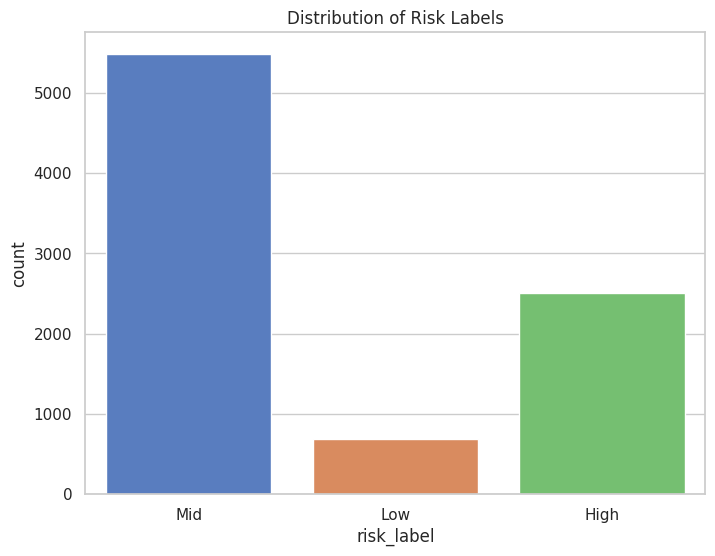

<ipython-input-27-4e9c7a0c38f8>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk_label', y=trait, data=df, ax=ax, palette='muted')
<ipython-input-27-4e9c7a0c38f8>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk_label', y=trait, data=df, ax=ax, palette='muted')
<ipython-input-27-4e9c7a0c38f8>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk_label', y=trait, data=df, ax=ax, palette='muted')
<ipython-input-27-4e9c7a0c38f8>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remove

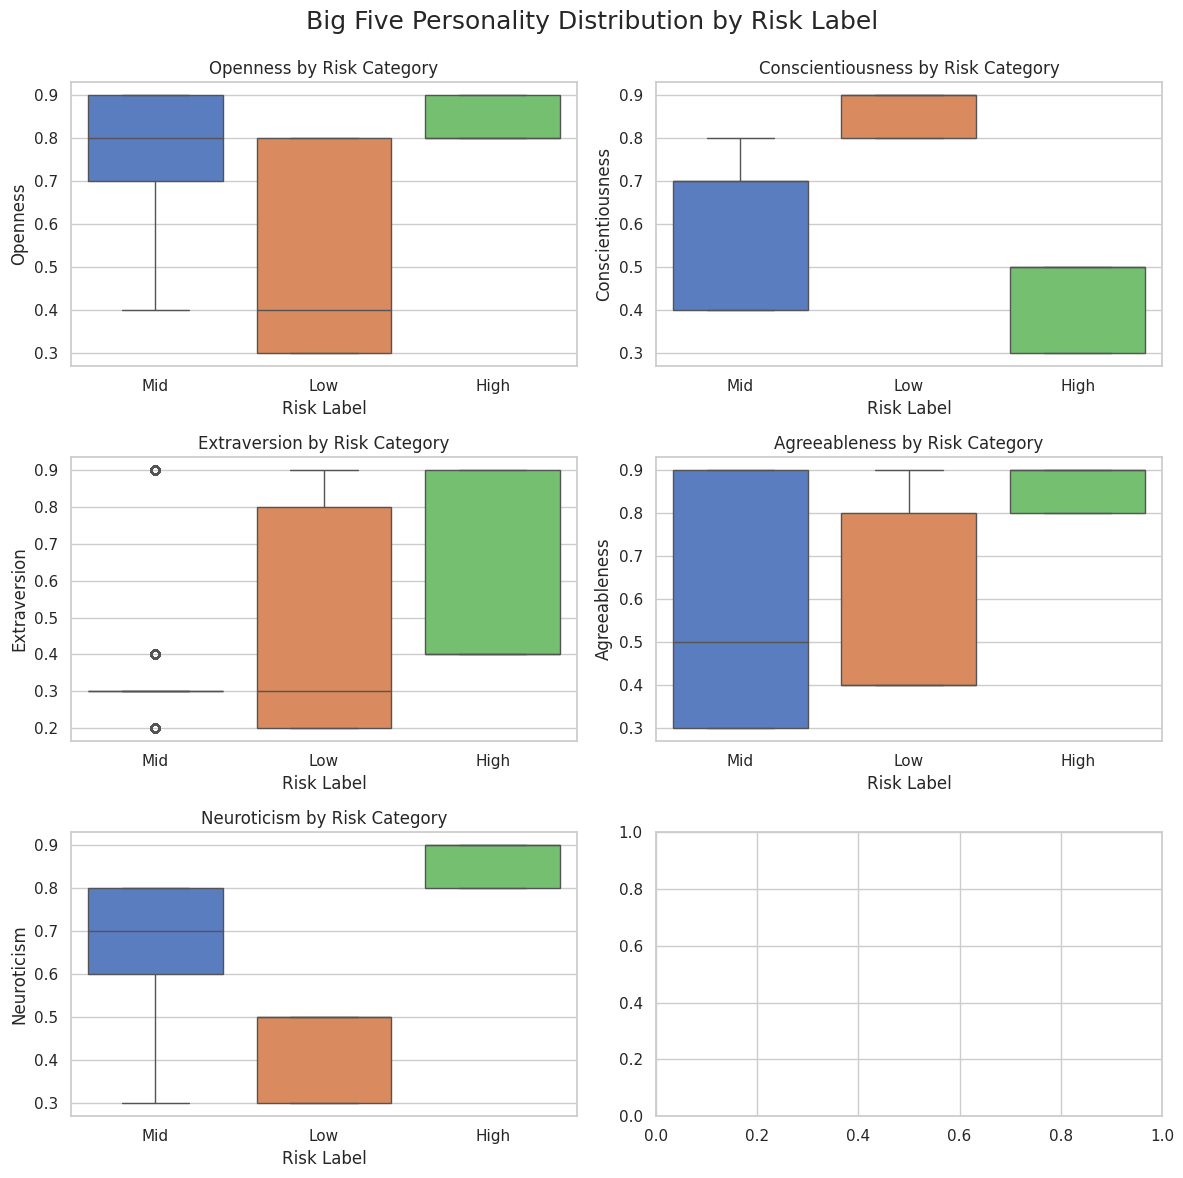

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

#  Display label distribution
print("\n Risk Label Distribution:")
print(df['risk_label'].value_counts())

#  Count plot for distribution visualization
plt.figure(figsize=(8, 6))
sns.countplot(x='risk_label', data=df, palette='muted')
plt.title('Distribution of Risk Labels')
plt.show()

#  Boxplot for distribution by risk label
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Big Five Personality Distribution by Risk Label', fontsize=18)

traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

for i, trait in enumerate(traits):
    ax = axes[i // 2, i % 2]

    sns.boxplot(x='risk_label', y=trait, data=df, ax=ax, palette='muted')

    ax.set_title(f"{trait} by Risk Category")
    ax.set_xlabel('Risk Label')
    ax.set_ylabel(trait)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [28]:
from sklearn.model_selection import train_test_split
import torch

# Features (text) and labels (Big Five scores)
X_text = df['posts'].tolist()
y_labels = torch.tensor(df[['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']].values, dtype=torch.float)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_text, y_labels, test_size=0.2, random_state=42)


In [29]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [30]:
from torch.utils.data import Dataset

class PersonalityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = PersonalityDataset(train_encodings, y_train)
test_dataset = PersonalityDataset(test_encodings, y_test)


In [31]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class DistilBertRegressor(nn.Module):
    def __init__(self):
        super(DistilBertRegressor, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)  # Add some regularization
        self.linear = nn.Linear(768, 5)  # Adjust output size (5 for Big Five traits)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        pooled_output = last_hidden_state[:, 0, :]  # Take [CLS] token representation
        dropped = self.dropout(pooled_output)
        return self.linear(dropped)

# Initialize the model
model = DistilBertRegressor()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [32]:
from torch.optim import AdamW
from torch.utils.data import DataLoader

# Training parameters
epochs = 10  # Increased from 1 to 5
batch_size = 16  # Increased from 8 to 16
learning_rate = 1e-5  # Reduced from 2e-5 to 1e-5

# Model & Optimizer
model = DistilBertRegressor()
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
criterion = nn.MSELoss()

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertRegressor(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

In [33]:
print(f"Training samples: {len(train_dataset)}")
for i in range(3):
    print(train_dataset[i])


Training samples: 6940
{'input_ids': tensor([  101,  1045,  3866,  2035,  1996,  2422,  2057,  3685,  2156,  2011,
         4938, 18629, 12171,  2049,  1037,  3492,  3522,  2338,  2234,  2041,
         1999,  2089,  2021,  2009,  2001,  3432,  6429, 10760,  4326,  1998,
         3376, 14038,  2015,  1997, 10927, 20920,  4649,  2135,  2063, 14290,
         2155,  2052,  2215,  2033,  2000,  3828,  1996,  1016,  4551,  2111,
         1045,  2052,  2191,  1996,  2168,  3601,  2009,  2052,  2022,  9202,
         2593,  2126,  2072,  2123,  2102,  2404,  2172,  4518,  1999, 16371,
         5017,  6779,  2021,  1045,  6618,  2009,  2481,  2102,  3480,  2000,
         3046,  1998,  2009,  2790,  2066,  4569,  4312,  4182,  2486,  2193,
         1021, 10461,  2193,  1020,  6180,  2193,  2340,  3969,  9720, 10085,
         4263,  2040,  7619,  8837, 11189, 18874,  5944, 22174,  1996,  2376,
         1997,  7935,  2502,  9748,  3399,  2331,  3602,  1998,  2060,  8750,
         2015, 10661,  8286

In [34]:
print(y_train.shape)  # Should be (num_samples, 5)
print(y_train[:5])    # Should print actual values


torch.Size([6940, 5])
tensor([[0.7000, 0.7000, 0.3000, 0.9000, 0.8000],
        [0.9000, 0.3000, 0.9000, 0.8000, 0.8000],
        [0.9000, 0.4000, 0.9000, 0.5000, 0.6000],
        [0.9000, 0.3000, 0.9000, 0.8000, 0.8000],
        [0.9000, 0.4000, 0.9000, 0.5000, 0.6000]])


In [35]:
for batch in train_loader:
    print(batch.keys())
    break


dict_keys(['input_ids', 'attention_mask', 'labels'])


In [36]:
class CustomDataset(torch.utils.data.Dataset):
    def __getitem__(self, idx):
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': label}  # Ensure 'label' exists


In [37]:
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")

    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

100%|██████████| 434/434 [05:10<00:00,  1.40it/s]


Epoch 1, Training Loss: 0.0533
Epoch 1, Validation Loss: 0.0389


100%|██████████| 434/434 [05:13<00:00,  1.38it/s]


Epoch 2, Training Loss: 0.0427
Epoch 2, Validation Loss: 0.0361


100%|██████████| 434/434 [05:14<00:00,  1.38it/s]


Epoch 3, Training Loss: 0.0381
Epoch 3, Validation Loss: 0.0335


100%|██████████| 434/434 [05:13<00:00,  1.38it/s]


Epoch 4, Training Loss: 0.0353
Epoch 4, Validation Loss: 0.0330


100%|██████████| 434/434 [05:14<00:00,  1.38it/s]


Epoch 5, Training Loss: 0.0330
Epoch 5, Validation Loss: 0.0325


100%|██████████| 434/434 [05:14<00:00,  1.38it/s]


Epoch 6, Training Loss: 0.0296
Epoch 6, Validation Loss: 0.0334


100%|██████████| 434/434 [05:14<00:00,  1.38it/s]


Epoch 7, Training Loss: 0.0266
Epoch 7, Validation Loss: 0.0342


100%|██████████| 434/434 [05:14<00:00,  1.38it/s]


Epoch 8, Training Loss: 0.0229
Epoch 8, Validation Loss: 0.0355


100%|██████████| 434/434 [05:13<00:00,  1.38it/s]


Epoch 9, Training Loss: 0.0195
Epoch 9, Validation Loss: 0.0358


100%|██████████| 434/434 [05:14<00:00,  1.38it/s]


Epoch 10, Training Loss: 0.0168
Epoch 10, Validation Loss: 0.0356


In [38]:
from sklearn.metrics import mean_squared_error, accuracy_score, precision_recall_fscore_support

model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

In [39]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Put model in evaluation mode
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Convert to NumPy for analysis
predictions = np.array(predictions)
actuals = np.array(actuals)

# Compute Regression Metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

# Print results
print(f"Final Test MSE: {mse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R² Score: {r2:.4f}")


Final Test MSE: 0.0356
Final Test MAE: 0.1419
Final Test R² Score: 0.1068


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

#  Use the real preprocessed Big Five scores and risk labels
X = df[['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']].values
y = df['risk_label'].values  # Use the real risk labels

# Encode labels (Low = 0, Mid = 1, High = 2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#  Define LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # Last hidden state
        out = self.fc(hn[-1])
        return out

#  Model Parameters
input_size = 5  # Big Five traits
hidden_size = 64
num_layers = 2
output_size = 3  # Three classes: Low, Mid, High

#  Initialize Model
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#  Training Loop
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

#  Evaluate Model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_labels = torch.argmax(y_pred, dim=1).numpy()
    accuracy = accuracy_score(y_test, y_pred_labels)

print(f"Test Accuracy: {accuracy:.4f}")


#  Prediction Function using Real Labels
def predict_mental_health(personality_scores):
    """
    Predicts mental health risk using the trained LSTM model.
    Args:
        personality_scores (list): List of Big Five scores [O, C, E, A, N]
    """
    # Normalize the input
    personality_scores = scaler.transform([personality_scores])  # Normalize
    input_tensor = torch.tensor(personality_scores, dtype=torch.float32).unsqueeze(0)  # Shape: (1, sequence_length, input_size)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_label = torch.argmax(output, dim=1).item()

    return label_encoder.inverse_transform([predicted_label])[0]


#  Example Prediction using Real Data
# Select a random sample from the preprocessed data
random_index = np.random.randint(0, len(X))
example_personality = X[random_index]  # Use real Big Five scores
predicted_risk = predict_mental_health(example_personality)
print(f"Predicted Mental Health Risk: {predicted_risk}")


Epoch [10/100], Loss: 1.1192
Epoch [20/100], Loss: 1.0785
Epoch [30/100], Loss: 1.0221
Epoch [40/100], Loss: 0.9387
Epoch [50/100], Loss: 0.8227
Epoch [60/100], Loss: 0.6876
Epoch [70/100], Loss: 0.5591
Epoch [80/100], Loss: 0.4441
Epoch [90/100], Loss: 0.3445
Epoch [100/100], Loss: 0.2631
Test Accuracy: 0.9153
Predicted Mental Health Risk: Mid


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Test Accuracy: 0.9153

 Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       495
         Low       0.00      0.00      0.00       147
         Mid       0.88      1.00      0.94      1093

    accuracy                           0.92      1735
   macro avg       0.63      0.67      0.65      1735
weighted avg       0.84      0.92      0.88      1735



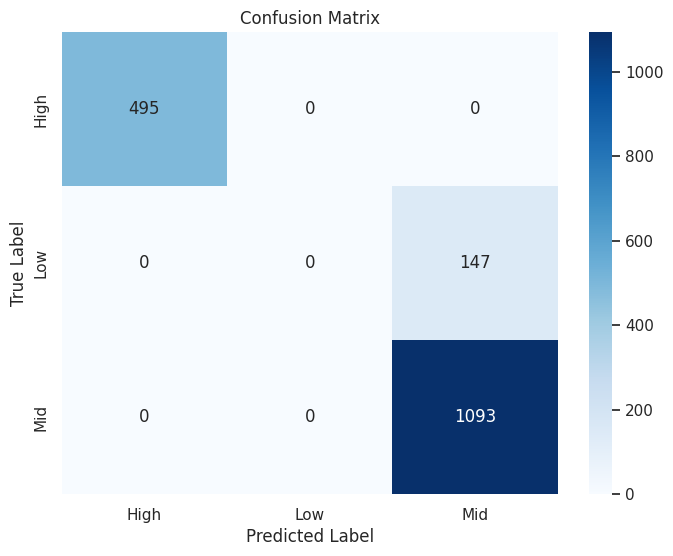

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

#  Evaluate Model with Additional Metrics
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_labels = torch.argmax(y_pred, dim=1).numpy()

#  Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)

#  Classification Report (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_)

#  Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

#  Display Metrics
print(f"\n Test Accuracy: {accuracy:.4f}")
print("\n Classification Report:\n")
print(report)

#  Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
